In [1]:
import pandas as pd

df = pd.read_csv('./data/cabaventa.csv')
df.shape

(183810, 27)

## Limpieza Texto y Columnas

In [2]:
from cleaning import CleaningData
#instanciamos Cleaning Data con df

cleaned = CleaningData(data=df)

In [3]:
#Quitamos columnas 
cols_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', #columnas que vinieron mal en la bajada
                'operation_type', #todos son 'venta'
                'l1', # todos son 'Argentina'
                'l2', # todos son "Capital Federal"
                'ad_type', #todas las filas iguales 
                'l4', #todas las filas nulas preferible el dato de lat y long
                'l5', #columna con todas las filas nulas
                'l6', #columna con todas las filas nulas
                'created_on', #la columna created_on es igual a la columna start_date
               ]
cleaned.drop_columns(columns=cols_to_drop)
cleaned.data.shape

Cleaning columns with no valuable information...



(183810, 17)

In [4]:
#Limpieza title
params = {'lowering':True,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="title", params=params)
cleaned.data.shape

(183810, 18)

In [5]:
#Limpieza description
params = {'lowering':True,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="description", params=params)
cleaned.data.shape

(183810, 19)

In [6]:
#Limpieza l3
params = {'lowering':False,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="l3", params=params)
cleaned.data.shape

(183810, 20)

# Imputación de barrio correcto

In [8]:
from geoBarrios import *

geoBarrios = geoBarrios() #devuelve un dict (datos GCBA)

from tqdm import tqdm
barrio_imput = []
for tup in tqdm([(nbhd, lon,lat) for nbhd, lon, lat in zip(df.l3, df.lon,df.lat)]):
    barrio = coord_to_nbhd(coord = tup[1:],est_nbhd=tup[0], polygons_dict=geoBarrios) #usando librería shapley
    barrio_imput.append(barrio)

cleaned.data['barrio_ok'] = barrio_imput

(array([1.7236e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([3.39116561e-101, 3.23019767e-007, 6.46039535e-007, 9.69059302e-007,
        1.29207907e-006, 1.61509884e-006, 1.93811860e-006, 2.26113837e-006,
        2.58415814e-006, 2.90717791e-006, 3.23019767e-006]),
 <BarContainer object of 10 artists>)

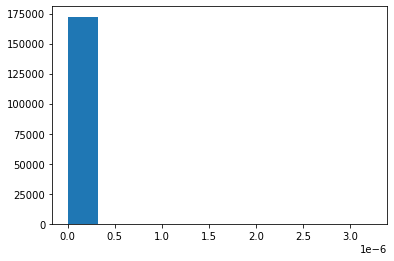

In [27]:
import matplotlib.pyplot as plt
plt.hist(10**cleaned.data.lon)

In [ ]:
cleaned.data.loc[(cleaned.data.barrio_ok!=cleaned.data.l3.cleaned), ["lon","lat",]]

Casos: 

1. ($Barrio$, $None$) --> No existe coordenada en CABA
2. ($None$, $Barrio$) --> Recupera dato
3. ($None$, $None$) --> No modifica
4. ($Barrio_a$, $Barrio_b$) --> Corrige
5. ($Barrio_a$, $Barrio_a$) --> Ratifica

In [18]:
cleaned.data['result_barrio'] = np.where((cleaned.data.l3_cleaned.isna()==False) & (cleaned.data.barrio_ok.isna()),1,
                                            np.where((cleaned.data.l3_cleaned.isna()) & (cleaned.data.barrio_ok.isna()==False),2,
                                                    np.where((cleaned.data.l3_cleaned.isna()) & (cleaned.data.barrio_ok.isna()),3,
                                                             np.where((cleaned.data.l3_cleaned.isna()==False) & (cleaned.data.barrio_ok.isna()==False) &
                                         (cleaned.data.l3_cleaned != cleaned.data.barrio_ok),4,
                                                                     np.where((cleaned.data.l3_cleaned.isna()==False) & (cleaned.data.barrio_ok.isna()==False) &
                                         (cleaned.data.l3_cleaned == cleaned.data.barrio_ok),5,6)))))

100*cleaned.data.result_barrio.value_counts(normalize=True)

5    68.498994
1    20.587563
4     9.908601
3     0.956422
2     0.048420
Name: result_barrio, dtype: float64